In [44]:
import math
import numpy as np
import random
import time
import matplotlib.pyplot as plt

# A class representing a single not in the digest
class Node():
  def __init__(self, id, count, leaf):
    self.id = id
    self.count = count
    self.leaf = leaf

  # increase self count
  def increase(self, step):
    self.count += step

  # getter functions for parent/children/sibling ids
  def id_parent(self):
    if self.id != 1:
      return int(math.floor(self.id / 2.0))
    return None

  def id_children(self):
    return {'left' : 2 * self.id, 'right' : 2 * self.id + 1}

  def id_sibling(self):
    if self.id == 1:
      return None
    if self.id % 2 != 0:
      return self.id - 1
    else:
      return self.id + 1

In [53]:
# A class representing qdigest
class QTree():
  def __init__(self, size, compression):
    self.empty = Node(-1, 0, False)
    self.size = size
    self.elements = []
    self.id = 1
    self.k = compression

  # fucntion for merging two qdigest trees
  def merge(self, tree):
    size = max(self.size, tree.size)
    new_tree = QTree(size, self.k)
    new_tree.elemetns = self.elements
    for n in tree.elements:
      new_tree.modify(n.id, n.count)

    new_tree.compression()

    return new_tree

  # getter for the tree height
  def get_height(self):
    return int(math.ceil(math.log(self.size, 2)))

  # retrieve a node by id
  def get_node(self, id):
    try:
      node = next((x for x in self.elements if x.id == id))
      return node
    except:
      return self.empty

  # retrieve the sum of all node counts
  def get_frequency_sum(self):
    freq = 0
    for el in self.elements:
      freq += el.count
    return freq

  # property 1: count of a non-leaf node must be less than n/k
  # k - compression factor
  def frequency_property(self, node):
    if node.id == 1 or node.leaf:
      return False
    else:
      return node.count <= int(math.floor(self.get_frequency_sum() / self.k))

  # property 2: total count of a node, its parents and siblings, with
  # the exception of the root must be greater than n/k
  def merge_property(self, node):
    num_parents = self.get_node(node.id_parent()).count
    num_siblings = self.get_node(node.id_sibling()).count

    all_counts = node.count + num_parents + num_siblings

    return all_counts <= int(math.floor(self.get_frequency_sum() / self.k))
  
  # remove a node by id
  def remove(self, id):
    node = self.get_node(id)
    if node is not self.empty:
      self.elements.remove(node)

  # insert a new node or modify current
  def modify(self, id, increment):
    current_node = self.get_node(id)
    if current_node is not self.empty:
      current_node.increase(increment)
    else:
      current_node = Node(id, increment, False)
      self.elements.append(current_node)

  # insert new data
  def insert(self, data):
    if data <= self.size:
      leaf_id = int(math.pow(2, self.get_height()) + data - 1)
      self.modify(leaf_id, 1)

  # compress qdigest
  def compression(self):
    for i in range(self.get_height(), 0, -1):
      current_level = []
      for node in self.elements:
        if node.id >= math.pow(2, i) and node.id < math.pow(2, i + 1):
          current_level.append(node)
      current_level = sorted(current_level, key = id)
      for node in current_level:
        if self.merge_property(node):
          a = node.count + self.get_node(node.id_sibling()).count
          self.modify(node.id_parent(), a)
          self.remove(node.id)
          self.remove(node.id_sibling())

  # return quantiles
  def quantile(self, fractions):
    sum = {}
    results = {}
    for f in fractions:
      if f > 0 and f < 1:
        sum[str(f)] = 0
        results[str(f)] = None

    def traverse_node(id):
      node = self.get_node(id)
      if node.id == -1:
        node = Node(id, 0, False)
      return node

    def dfs(node):
      if node and node.id < 2 * self.size:
        children = node.id_children()
        left = traverse_node(children['left'])
        right = traverse_node(children['right'])

        for node in dfs(left):
          yield node
        for node in dfs(right):
          yield node
        
        for f in fractions:
          freq_sum = self.get_frequency_sum()
          if not results[str(f)] and node.count + sum[str(f)] < f * freq_sum:
            sum[str(f)] = sum[str(f)] + node.count
          else:
            results[str(f)] = sum[str(f)]
    
    [n for n in dfs(traverse_node(1))]
    return results

In [40]:
# create digests
def create_digest():
  digest = QTree(10, 7)
  for i in range(100):
    digest.insert(random.randint(1, 20))
  return digest

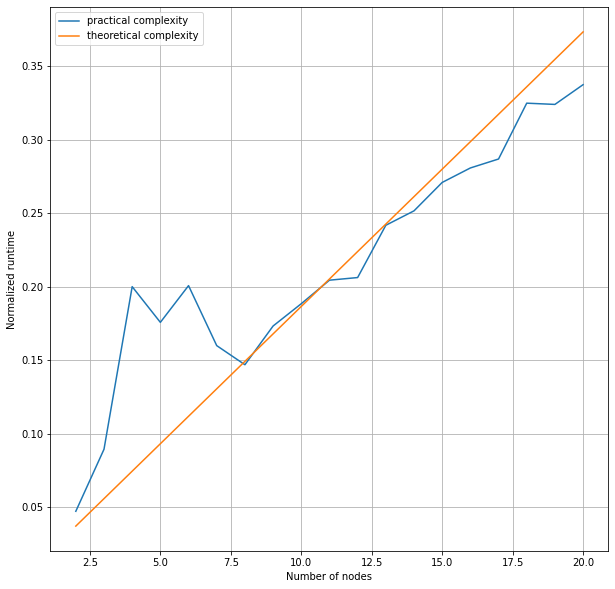

In [52]:
nodes = np.linspace(2, 20, num = 19).astype(int)
times = []

for n in nodes:
  digest = create_digest()
  start = time.time()
  for i in range(n):
    digest2 = create_digest()
    digest = digest.merge(digest2)

  digest.quantile((0.25, 0.5, 0.75))
  times.append(time.time() - start)

times = np.array(times)
normalized_t = times / np.sqrt(np.sum(times**2))

complexity_scores = []
for i in nodes:
  complexity_scores.append(i * np.log(10))

c = np.array(complexity_scores)
normalized_c = c / np.sqrt(np.sum(c**2))

plt.figure(figsize=(10, 10))
plt.plot(nodes, normalized_t, label='practical complexity')
plt.plot(nodes, normalized_c, label='theoretical complexity')
plt.legend()
plt.grid()
plt.xlabel('Number of nodes')
plt.ylabel('Normalized runtime')
plt.show()